In [283]:
import math
import random
import matplotlib.pyplot as plt
from PIL import Image

In [284]:
def load_config(path):
    config = {}
    with open(path, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=")
                config[k] = int(v)
    return config

In [285]:
def relu(x):
    return max(0.0, x)


def relu_derivative(x):
    return 1.0 if x > 0 else 0.0


def softmax(logits):
    max_logit = max(logits)
    exps = [math.exp(i - max_logit) for i in logits]
    s = sum(exps)
    return [j / s for j in exps]

In [286]:
def conv2d(image, kernel):
    h, w = len(image), len(image[0])
    kh, kw = len(kernel), len(kernel[0])
    out_h, out_w = h - kh + 1, w - kw + 1
    output = []
    for i in range(out_h):
        row = []
        for j in range(out_w):
            val = 0.0
            for ki in range(kh):
                for kj in range(kw):
                    val += image[i + ki][j + kj] * kernel[ki][kj]
            row.append(val)
        output.append(row)
    return output


def max_pool2d(image, size):
    h, w = len(image), len(image[0])
    output = []
    for i in range(0, h, size):
        row = []
        for j in range(0, w, size):
            patch = [
                image[i + m][j + n]
                for m in range(size)
                for n in range(size)
                if i + m < h and j + n < w
            ]
            row.append(max(patch))
        output.append(row)
    return output


def flatten(image):
    return [pixel for row in image for pixel in row]


def dense_forward(inputs, weights, biases):
    output = []
    for j in range(len(biases)):
        s = sum(inputs[i] * weights[i][j]
            for i in range(len(inputs))) + biases[j]
        output.append(s)
    return output

In [287]:
def cross_entropy(probs, label):
    return -math.log(probs[label] + 1e-9)


def gradient(probs, label):
    num_classes = len(probs)
    y = [0.0] * num_classes
    y[label] = 1.0

    grad = [0.0] * num_classes

    for i in range(num_classes):
        for j in range(num_classes):
            dL_dp = -y[j] / (probs[j] + 1e-9)
            if i == j:
                dp_dz = probs[j] * (1 - probs[j])
            else:
                dp_dz = -probs[i] * probs[j]
            grad[i] += dL_dp * dp_dz

    return grad

In [288]:
def update_dense(inputs, weights, biases, grad_output, lr):
    for i in range(len(inputs)):
        for j in range(len(grad_output)):
            weights[i][j] -= lr * inputs[i] * grad_output[j]
    for j in range(len(grad_output)):
        biases[j] -= lr * grad_output[j]

In [289]:
class CNN:
    def __init__(self, config_path):
        self.config = load_config(config_path)
        self.kernel = self.init_kernel(self.config["conv1_kernel"])
        self.pool_size = self.config["pooling_size"]
        self.losses = []
        conv_out = self.config["input_size"] - self.config["conv1_kernel"] + 1
        pooled = conv_out // self.pool_size
        flat_size = pooled * pooled
        self.dense_weights = [[random.uniform(-0.05, 0.05) for _ in range(
            self.config["dense_units"])] for _ in range(flat_size)]
        self.dense_biases = [0.0 for _ in range(self.config["dense_units"])]

    def init_kernel(self, size):
        return [[random.uniform(-1, 1) for _ in range(size)] for _ in range(size)]

    def forward(self, image):
        x = conv2d(image, self.kernel)
        x = [[relu(v) for v in row] for row in x]
        x = max_pool2d(x, self.pool_size)
        flat = flatten(x)
        logits = dense_forward(flat, self.dense_weights, self.dense_biases)
        return softmax(logits)

    def predict(self, image):
        probs = self.forward(image)
        return probs.index(max(probs))

    def train(self, images, labels, epochs, lr):
        for epoch in range(epochs):
            total_loss = 0.0
            for img, label in zip(images, labels):
                x = conv2d(img, self.kernel)
                x = [[relu(v) for v in row] for row in x]
                x = max_pool2d(x, self.pool_size)
                flat = flatten(x)
                logits = dense_forward(
                    flat, self.dense_weights, self.dense_biases)
                probs = softmax(logits)

                loss = cross_entropy(probs, label)
                total_loss += loss

                grad = gradient(probs, label)
                update_dense(flat, self.dense_weights,
                             self.dense_biases, grad, lr)

            self.losses.append(total_loss)
            if ((epoch+1) % 10 == 0):
                print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

    def plotLossValue(self):
        plt.plot(range(1, len(self.losses)+1), self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Epochs")
        plt.grid()
        plt.show()

In [290]:
def normalize(base_path, num_classes, samples_per_class, size=28):
    images = []
    labels = []
    for label in range(num_classes):
        for i in range(samples_per_class):
            filename = f"{base_path}/{label}/{i}.png"
            try:
                img = Image.open(filename).convert("L")
                img = img.resize((size, size))
                pixels = list(img.getdata())
                pixels = [p / 255.0 for p in pixels]
                matrix = [pixels[j*size:(j+1)*size] for j in range(size)]
                images.append(matrix)
                labels.append(label)
            except:
                pass
    return images, labels


In [291]:
def show_image(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis("off")
    plt.show()

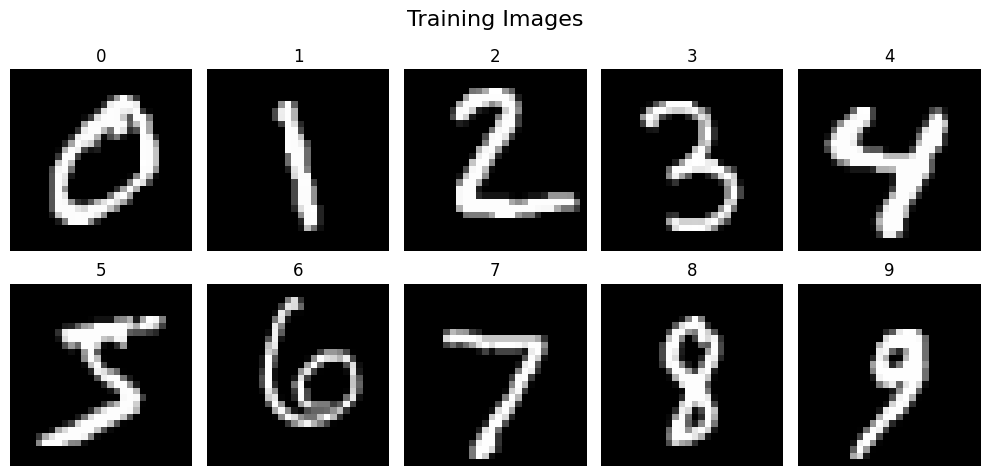

Epoch 10: Loss = 24.3245
Epoch 20: Loss = 11.3777
Epoch 30: Loss = 6.1811
Epoch 40: Loss = 4.0446
Epoch 50: Loss = 3.0169
Epoch 60: Loss = 2.4203
Epoch 70: Loss = 2.0288
Epoch 80: Loss = 1.7508
Epoch 90: Loss = 1.5425
Epoch 100: Loss = 1.3801


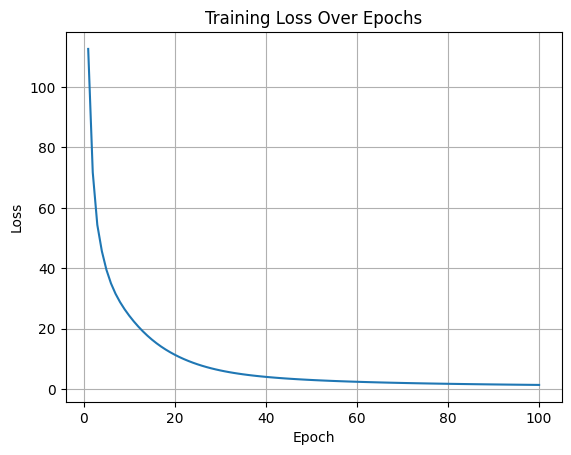

In [296]:
images, labels = normalize(
    "data/train", num_classes=10, samples_per_class=20)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Training Images", fontsize=16)

shown = [False] * 10
count = 0

for idx, (img, label) in enumerate(zip(images, labels)):
    if not shown[label]:
        ax = axes[count // 5][count % 5]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis("off")
        shown[label] = True
        count += 1
    if count == 100:
        break

plt.tight_layout()
plt.show()

model = CNN("config.txt")

model.train(images, labels, epochs=100, lr=0.1)
model.plotLossValue()

In [297]:
testImgs, testLabels = normalize("data/test", num_classes=10, samples_per_class=24)
correct_predictions = 0
total_predictions = len(testImgs)

for i in range(total_predictions):
    predicted_label = model.predict(testImgs[i])
    true_label = testLabels[i]

    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.75%


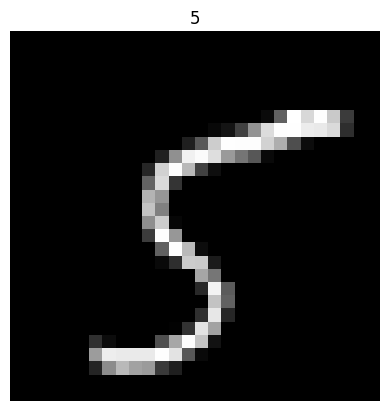

Predict 5


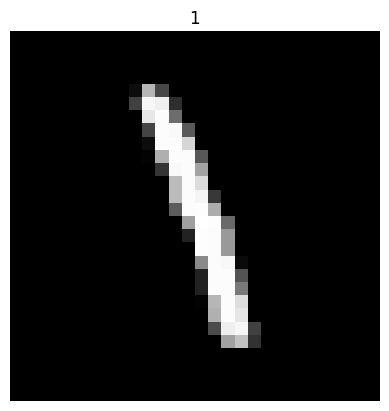

Predict: 5


In [294]:
testImgs, testLabels = normalize("data/test", num_classes=10, samples_per_class=5)
img1 = random.randint(0, len(testImgs) - 1)
img2 = random.randint(0, len(testImgs) - 1)

show_image(testImgs[img1], testLabels[img1])
print("Predict", model.predict(testImgs[img1]))

show_image(testImgs[img2], testLabels[img2])
print("Predict:", model.predict(testImgs[img2]))